# [Resolution-robust Large Mask Inpainting with Fourier Convolutions](https://arxiv.org/pdf/2109.07161.pdf)

This code is implementation of this paper and i will try to keep it simple and concise

I have to make:
1. Get data
2. Create and apply mask
3. Model
4. Loss func

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
!pip install -q tqdm
!pip install -q torchinfo

In [2]:
!git clone https://github.com/rounak890/image_blend_data.git
%cd image_blend_data
!ls

Cloning into 'image_blend_data'...
remote: Enumerating objects: 220, done.
remote: Counting objects: 100% (220/220), done.
remote: Compressing objects: 100% (209/209), done.
remote: Total 220 (delta 11), reused 220 (delta 11), pack-reused 0
Receiving objects: 100% (220/220), 11.66 MiB | 31.01 MiB/s, done.
Resolving deltas: 100% (11/11), done.
/content/image_blend_data
data.py  masks	real_images  trained_100_epochs.pth


array([[[  2,   2,  28],
        [  0,   0,  25],
        [  0,   0,  26],
        ...,
        [195, 205, 217],
        [195, 205, 217],
        [195, 205, 217]],

       [[  3,   3,  27],
        [  1,   1,  25],
        [  2,   2,  26],
        ...,
        [194, 204, 216],
        [195, 205, 217],
        [195, 205, 217]],

       [[  0,   0,  19],
        [  2,   4,  25],
        [  4,   6,  27],
        ...,
        [194, 204, 216],
        [194, 204, 216],
        [196, 206, 218]],

       ...,

       [[ 88,  73,  70],
        [ 84,  69,  66],
        [ 79,  65,  65],
        ...,
        [178, 141,  97],
        [188, 151, 107],
        [176, 142,  97]],

       [[ 73,  58,  51],
        [ 76,  61,  54],
        [ 85,  70,  63],
        ...,
        [186, 150, 102],
        [186, 152, 104],
        [189, 157, 106]],

       [[ 69,  55,  46],
        [ 69,  55,  46],
        [ 91,  77,  66],
        ...,
        [174, 141,  90],
        [179, 146,  95],
        [179, 148,  94]]], dtype=uint8)
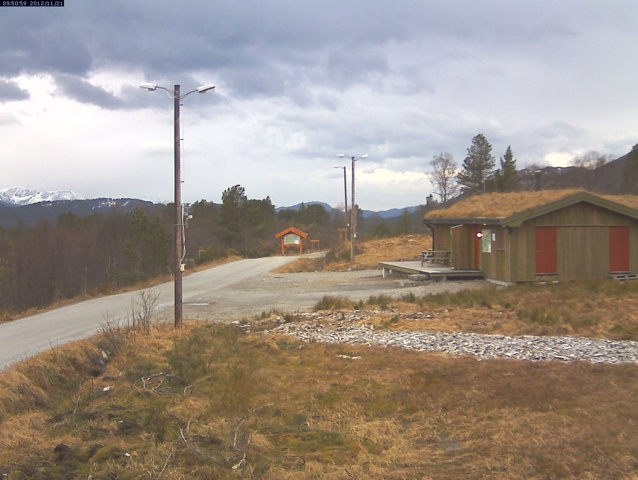

In [3]:
from pathlib import Path
import os

data_path = Path.cwd()   # ctually the current path has been changed to image_blend_data
# os.listdir(masks_path)

masks_path = data_path / 'masks/'
images_path = data_path / 'real_images/'

masks = list(masks_path.glob('*.png'))
images = list(images_path.glob('*.jpg'))

masks[0],images[0]          # these contains the data paths which can be accessed by plt.imread()
img  = plt.imread(images[0])
img

#Mask Generator

In [4]:
# make the dataset but before try how to make the mask for the images
import numpy as np
from numpy.random import uniform

marg = 10
p_irr = 0.5 # probability of a polygonal chain mask
min_n_irr = 3
max_n_irr = 5
max_l_irr = 200
max_w_irr = 150

min_n_box = 3
max_n_box = 5
min_s_box = 50
max_s_box = 150

def gen_large_mask(img_h, img_w, n):

  """ img_h: int, an image height
  img_w: int, an image width
  marg: int, a margin for a box starting coordinate
  p_irr: float, 0 <= p_irr <= 1, a probability of a polygonal chain mask

  min_n_irr: int, min number of segments
  max_n_irr: int, max number of segments
  max_l_irr: max length of a segment in polygonal chain
  max_w_irr: max width of a segment in polygonal chain

  min_n_box: int, min bound for the number of box primitives
  max_n_box: int, max bound for the number of box primitives
  min_s_box: int, min length of a box side
  max_s_box: int, max length of a box side"""

  mask = ones((img_h, img_w))

  if np.random.uniform(0,1) < p_irr: # generate polygonal chain
    n = uniform(min_n_irr, max_n_irr) # sample number of segments

  for _ in range(int(n)):
    y = uniform(0, img_h) # sample a starting point
    x = uniform(0, img_w)

    a = uniform(0, 360) # sample angle
    l = uniform(10, max_l_irr) # sample segment length
    w = uniform(5, max_w_irr) # sample a segment width

    # draw segment starting from (x,y) to (x_,y_) using brush of width w
    x_ = x + l * sin(a)
    y_ = y + l * cos(a)

    gen_segment_mask(mask, start=(x, y), end=(x_, y_), brush_width=w)
    x, y = x_, y_
  else: # generate Box masks
    n = uniform(min_n_box, max_n_box) # sample number of rectangles

    for _ in range(int(n)):
      h = uniform(min_s_box, max_s_box) # sample box shape
      w = uniform(min_s_box, max_s_box)

      x_0 = uniform(marg, img_w - marg + w) # sample upper-left coordinates of box
      y_0 = uniform(marg, img_h - marg - h)
      gen_box_mask(mask, size=(img_w, img_h), masked=(x_0, y_0, w, h))
  return mask

In [5]:
from numpy import *
from math import *
def gen_box_mask(mask, size, masked):
  x_0, y_0, w, h = masked
  x_0, y_0, w, h  = int(x_0), int(y_0), int(w), int(h)
  mask[x_0 : x_0 + w, y_0 : y_0 + h] = 0
  return mask

#gen_segment_mask(mask, start=(x, y), end=(x_, y_), brush_width=w)
def gen_segment_mask(mask, start, end, brush_width):
  x, y = start
  x_, y_ = end

  dx = x_ - x
  dy = y_ - y
  l = sqrt(dx**2 + dy**2)   # distance/length formula
  a = atan2(dy, dx)   # slope formula
  n = int(l / brush_width)
  for i in range(n):
    x_ = x + brush_width * cos(a)
    y_ = y + brush_width * sin(a)
    mask[int(x) : int(x_) + 1, int(y) : int(y_) + 1] = 0
    x, y = x_, y_
  return mask

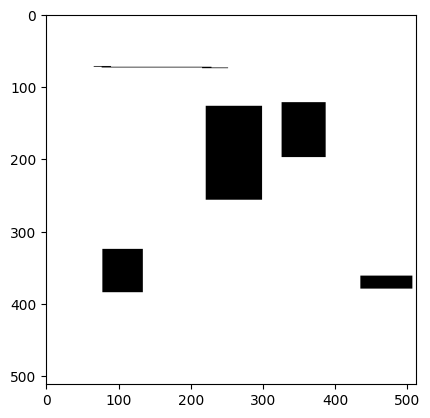

In [6]:
mk = gen_large_mask(512,512,4)
plt.imshow(mk,cmap='gray')

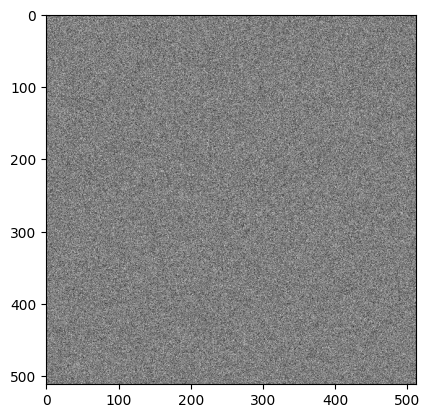

In [7]:
rimg = torch.randn((512,512)).numpy()
plt.imshow(rimg, cmap = "gray")

In [8]:
mk.shape,rimg.shape

((512, 512), (512, 512))

In [9]:
# (rimg*(mk == 0)).shape
rimg[mk == 0] = 0
rimg[mk != 0] = 1
rimg.shape

(512, 512)

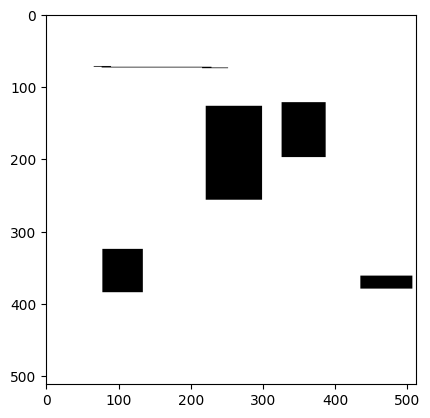

In [10]:
plt.imshow(rimg,cmap = "gray")

In [11]:
transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor()
])

late_transform = transforms.Compose([
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [12]:
!ls

data.py  masks	real_images  trained_100_epochs.pth


In [13]:
masked_imgs = data_path/"masked_imgs"

#Custom Dataset

In [62]:
from pathlib import Path
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split

class inpaint_dataset(Dataset):
  def __init__(self, transform ,split : str = "train" ):
    self.root_dir = Path(os.getcwd())
    self.transform = transform

    img_dir = self.root_dir/ "real_images"
    self.imgs = list(img_dir.glob("*.jpg"))

    self.train_imgs, self.val_imgs = train_test_split(self.imgs, test_size = 0.3,random_state = 42)
    if split == "train":
      self.imgs = self.train_imgs
    else:
      self.imgs = self.val_imgs
    # print(self.imgs[0])

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    img = self.imgs[idx].as_posix()  # to get the path only
    img = Image.open(img)
    img = self.transform(img)
    img2 = img.clone()
    mask = torch.tensor(gen_large_mask(img2.shape[1],img.shape[2],4))

    # print(img.shape)
    img[0,...][mask == 0] = 0   # i have been using mk the whole time instead of mask and trying to find the error fucking im
    img[1,...][mask == 0] = 0
    img[2,...][mask == 0] = 0

    # lets try matmul as used in paper instead of pur method
    # img = torch.matmul(img.to(torch.float),mask.to(torch.float))

    return torch.cat((img,mask.unsqueeze(0)), dim = 0)*255, img2,mask ; #NOW I'M ALSO RETURNING MASK # blurred image and correct image

In [63]:
train_dataset = inpaint_dataset(transform = transform)
m_img, img ,_= train_dataset[13]
m_img.shape

torch.Size([4, 512, 512])

In [44]:
# m_img = torch.tensor([[255,230,200],[255,230,200]])
# t = transforms.Resize(size = (2,3))
# t(m_img)
root_dir = Path(os.getcwd())
p = root_dir / "real_images/d16761-82.jpg"
# print(p)
x = cv2.imread(str(p))
# print
t = transforms.ToTensor()
t(x)

tensor([[[0.6078, 0.4314, 0.4196,  ..., 0.1294, 0.0863, 0.0627],
         [0.5882, 0.4902, 0.4000,  ..., 0.1216, 0.0902, 0.0784],
         [0.5961, 0.5529, 0.4118,  ..., 0.1176, 0.1059, 0.0980],
         ...,
         [0.3529, 0.3608, 0.3804,  ..., 0.4902, 0.5608, 0.4902],
         [0.2941, 0.3176, 0.4235,  ..., 0.4314, 0.4549, 0.4157],
         [0.2941, 0.3020, 0.3882,  ..., 0.3725, 0.4078, 0.3882]],

        [[0.3529, 0.3333, 0.6314,  ..., 0.1451, 0.0863, 0.0627],
         [0.3490, 0.3686, 0.5176,  ..., 0.1294, 0.0902, 0.0667],
         [0.3804, 0.3843, 0.3451,  ..., 0.1059, 0.0863, 0.0784],
         ...,
         [0.3765, 0.3843, 0.4157,  ..., 0.5451, 0.6118, 0.5451],
         [0.3176, 0.3412, 0.4588,  ..., 0.4863, 0.5059, 0.4706],
         [0.3176, 0.3255, 0.4235,  ..., 0.4275, 0.4588, 0.4314]],

        [[0.2706, 0.2549, 0.5647,  ..., 0.1216, 0.0627, 0.0392],
         [0.2471, 0.2706, 0.4431,  ..., 0.1059, 0.0667, 0.0471],
         [0.2353, 0.2549, 0.2431,  ..., 0.0902, 0.0745, 0.

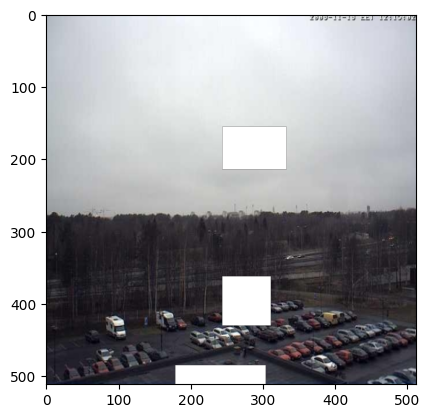

In [66]:
train_dataset = inpaint_dataset(transform = transform)
m_img, img,_ = train_dataset[13]
plt.imshow((m_img).to(torch.uint8).permute(1,2,0))

In [67]:
train_dataset = inpaint_dataset(split = "train",transform = transform)
test_dataset = inpaint_dataset(split = "test",transform = transform)
train_dataset, test_dataset

(<__main__.inpaint_dataset at 0x7e6ef7e7e800>,
 <__main__.inpaint_dataset at 0x7e6ef7e7e830>)

In [68]:
train_dataloader = DataLoader(train_dataset, batch_size = 2, shuffle = True) # batchsize 8 is too big
test_dataloader = DataLoader(test_dataset, batch_size = 2, shuffle = False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e6ef7e6bb50>,
 <torch.utils.data.dataloader.DataLoader at 0x7e6ef7e69db0>)

In [69]:
x,y,_ = train_dataset[0]
x.shape, y.shape

(torch.Size([4, 512, 512]), torch.Size([3, 512, 512]))

(-0.5, 511.5, 511.5, -0.5)

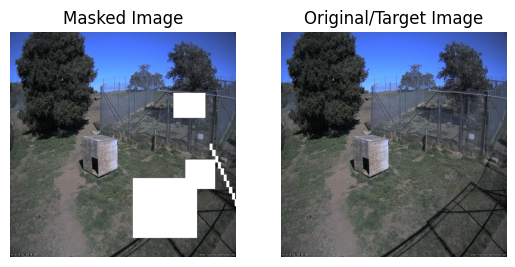

In [61]:
plt.subplot(121)
plt.imshow((x*255).to(torch.uint8).permute(1,2,0))
plt.title("Masked Image")
plt.axis("off")

plt.subplot(122)
plt.imshow(y.permute(1,2,0))
plt.title("Original/Target Image")
plt.axis("off")

In [70]:
x

tensor([[[ 46.0000,  46.0000,  48.0000,  ...,  38.0000,  35.0000,  33.0000],
         [ 46.0000,  45.0000,  48.0000,  ...,  39.0000,  37.0000,  36.0000],
         [ 48.0000,  47.0000,  49.0000,  ...,  39.0000,  37.0000,  38.0000],
         ...,
         [ 20.0000,  30.0000,  33.0000,  ...,  20.0000,  19.0000,  15.0000],
         [ 13.0000,  21.0000,  28.0000,  ...,  22.0000,  16.0000,  16.0000],
         [ 13.0000,  16.0000,  26.0000,  ...,  20.0000,  13.0000,  14.0000]],

        [[ 64.0000,  65.0000,  68.0000,  ...,  50.0000,  47.0000,  45.0000],
         [ 64.0000,  64.0000,  67.0000,  ...,  51.0000,  49.0000,  48.0000],
         [ 66.0000,  66.0000,  68.0000,  ...,  52.0000,  50.0000,  51.0000],
         ...,
         [ 20.0000,  30.0000,  34.0000,  ...,  21.0000,  20.0000,  16.0000],
         [ 16.0000,  24.0000,  31.0000,  ...,  23.0000,  17.0000,  17.0000],
         [ 16.0000,  19.0000,  29.0000,  ...,  21.0000,  14.0000,  15.0000]],

        [[126.0000, 128.0000, 131.0000,  ...

In [54]:
x

tensor([[[0.1804, 0.1804, 0.1882,  ..., 0.1490, 0.1373, 0.1294],
         [0.1804, 0.1765, 0.1882,  ..., 0.1529, 0.1451, 0.1412],
         [0.1882, 0.1843, 0.1922,  ..., 0.1529, 0.1451, 0.1490],
         ...,
         [0.0784, 0.1176, 0.1294,  ..., 0.0784, 0.0745, 0.0588],
         [0.0510, 0.0824, 0.1098,  ..., 0.0863, 0.0627, 0.0627],
         [0.0510, 0.0627, 0.1020,  ..., 0.0784, 0.0510, 0.0549]],

        [[0.2510, 0.2549, 0.2667,  ..., 0.1961, 0.1843, 0.1765],
         [0.2510, 0.2510, 0.2627,  ..., 0.2000, 0.1922, 0.1882],
         [0.2588, 0.2588, 0.2667,  ..., 0.2039, 0.1961, 0.2000],
         ...,
         [0.0784, 0.1176, 0.1333,  ..., 0.0824, 0.0784, 0.0627],
         [0.0627, 0.0941, 0.1216,  ..., 0.0902, 0.0667, 0.0667],
         [0.0627, 0.0745, 0.1137,  ..., 0.0824, 0.0549, 0.0588]],

        [[0.4941, 0.5020, 0.5137,  ..., 0.3647, 0.3451, 0.3333],
         [0.4941, 0.4980, 0.5176,  ..., 0.3686, 0.3569, 0.3490],
         [0.5059, 0.5098, 0.5255,  ..., 0.3725, 0.3608, 0.

#Model Making

##old wrong models

In [21]:
# from numpy import fft
from torch import fft

class inpainting_model(nn.Module):   # it is a try for rough replication of the architecture
  def __init__(self):
    super().__init__()
    self.last_conv = nn.Conv2d(4,3,1)   # last layer to convert the output's 4 dimensions to 3 dimensions
    self.convl_1 = nn.Conv2d(1, 2, 3, 1, 1)  # of local
    self.convl_2 = nn.Conv2d(1, 2, 3, 1, 1) # of local
    self.layerl_1 = nn.Sequential(
        nn.BatchNorm2d(2),
        nn.ReLU()
    )

    self.conv_g1 = nn.Conv2d(1, 2, 3, 1, 1) # of global
    self.conv_g2 = nn.Conv2d(1, 2, 3, 1, 1) # of global
    self.layerl_2 = nn.Sequential(
        nn.BatchNorm2d(2),
        nn.ReLU()
    )
    self.convl_1_2 = nn.Conv2d(1, 2, 3, 1, 1)  # of local
    self.convl_2_2 = nn.Conv2d(1, 2, 3, 1, 1) # of local
    self.layerl_1_2 = nn.Sequential(
        nn.BatchNorm2d(2),
        nn.ReLU()
    )

    self.conv_g1_2 = nn.Conv2d(1, 2, 3, 1, 1) # of global
    self.conv_g2_2 = nn.Conv2d(1, 2, 3, 1, 1) # of global
    self.layerl_2_2 = nn.Sequential(
        nn.BatchNorm2d(2),
        nn.ReLU()
    )

  def special_transform(self,global1):   # g2 will go through this one
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.layer2_real = nn.Sequential(
        nn.Conv2d(64, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.layer2_img = nn.Sequential(
        nn.Conv2d(64, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.final_conv = nn.Conv2d(64,2,1)   # it might be wrong --> they have written size of kernel as 1X1 not told to use Conv1d

    self.layer1 =  self.layer1.to(global1.device)
    self.layer2_real =  self.layer2_real.to(global1.device)
    self.layer2_img =  self.layer2_img.to(global1.device)
    self.final_conv =  self.final_conv.to(global1.device)

    # print(f"Shape of input to special transform : {global1.shape}")
    global1 = self.layer1(global1)               # here we have ERRORRRRRRRRRRRRRRRrrrrrrrrrrrr
    z = global1 # for applying residual network
    # print(f"Shape original : {global1.shape}")
    global1 = fft.rfft2(global1)    # after this the shape got changed            ,dim = 0
    # print(f"Shape after rfft2 : {global1.shape}")
    global1_real = self.layer2_real(global1.real.float())   # spliting the inputs so they can be worked upon
    global1_img = self.layer2_img(global1.imag.float())                                                          # blunder i put real instead of img
    global1 = global1_real + 1j * global1_img   # combining the inputs to go furthur
    # print(f"Shape after combining : {global1.shape}")
    global1 = fft.irfft2(global1)
    # print(f"Shape after irfft2 : {global1.shape}")
    global1 = global1 + z
    # print(f"Shape before final conv : {global1.squeeze().shape}")
    global1 = self.final_conv(global1.squeeze())
    return global1.unsqueeze(0)

  def special_transform_2(self,global1):   # g2 will go through this one
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.layer2_real = nn.Sequential(
        nn.Conv2d(64, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.layer2_img = nn.Sequential(
        nn.Conv2d(64, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.final_conv = nn.Conv2d(64,2,1)   # it might be wrong   -- chanes 1->2

    #moving on to proper device
    self.layer1 =  self.layer1.to(global1.device)
    self.layer2_real =  self.layer2_real.to(global1.device)
    self.layer2_img =  self.layer2_img.to(global1.device)
    self.final_conv =  self.final_conv.to(global1.device)

    global1 = self.layer1(global1)


    z = global1 # for applying residual network
    global1 = fft.rfft2(global1)
    global1_real = self.layer2_real(global1.real.float())
    global1_img = self.layer2_img(global1.imag.float())
    global1 = global1_real + 1j * global1_img
    global1 = fft.irfft2(global1)
    global1 = global1 + z
    global1 = self.final_conv(global1.squeeze())
    return global1.unsqueeze(0)

  def ffc_1(self,x):
    l1,l2,g1,g2 = x[:,0,...], x[:,1,...], x[:,2,...], x[:,3,...]  # supposing that the structure of data is -------------> [BATCH, COLOR CHANNELS, HEIGHT, WIDTH]
    l1,l2,g1,g2 = l1.unsqueeze(1), l2.unsqueeze(1), g1.unsqueeze(1), g2.unsqueeze(1)

    l1 = self.convl_1(l1)
    l2 = self.convl_2(l2)
    g1 = self.conv_g1(g1)
    g2 = self.special_transform(g2)    # g2 will go thourgh special transform which is the thing that try to capture the global details

    # print(f"Shape of l1 : {l1.shape}")
    # print(f"Shape of l2 : {l2.shape}")
    # print(f"Shape of g1 : {g1.shape}")
    # print(f"Shape of g2 : {g2.shape}")

    l = l1 + g1
    g = l2 + g2.squeeze()
    # print(f"Shape of l : {l2.shape}")
    # print(f"Shape of g : {g1.shape}")

    l = self.layerl_1(l)
    g = self.layerl_2(g)

    return torch.cat([l,g], dim=1)

  def ffc_2(self,x):
    l1,l2,g1,g2 = x[:,0,...], x[:,1,...], x[:,2,...], x[:,3,...]  # supposing that the structure of data is -------------> [BATCH, COLOR CHANNELS, HEIGHT, WIDTH]
    l1,l2,g1,g2 = l1.unsqueeze(1), l2.unsqueeze(1), g1.unsqueeze(1), g2.unsqueeze(1) #  BATCH AND NON BATCH PROBLEM

    l1 = self.convl_1_2(l1)
    l2 = self.convl_2_2(l2)
    g1 = self.conv_g1_2(g1)
    g2 = self.special_transform_2(g2)    # g2 will go thourgh special transform which is the thing that try to capture the global details

    l = l1 + g1             # mistake i dont have to add here rather have to cat here
    g = l2 + g2.squeeze()

    l = self.layerl_1_2(l)
    g = self.layerl_2_2(g)

    return torch.cat((l,g), dim=1)

  def forward(self,x):
    # split the x into local and global branch
    # then split the local and global branch into single single channels named l1,l2,g1,g2
    z = x
    # print(f"shape of item 1: {z.shape}")
    x = self.ffc_1(x)
    # print(f"shape after ffc1: {x.shape}")
    x = self.ffc_2(x)
    # print(f"shape of item 2: {x.shape}")
    x = x + z
    return x


# righr now downlscaling and upscaling part is remaining as first i would like to try without it HOPE SO IT WORKS

In [22]:
# from numpy import fft
from torch import fft

class inpainting_model_v2(nn.Module):   # it is a try for rough replication of the architecture
  def __init__(self):
    super().__init__()
    self.last_conv = nn.Conv2d(4,3,1)   # last layer to convert the output's 4 dimensions to 3 dimensions
    self.convl_1 = nn.Conv2d(1, 2, 3, 1, 1)  # of local
    self.convl_2 = nn.Conv2d(1, 2, 3, 1, 1) # of local
    self.layerl_1 = nn.Sequential(
        nn.BatchNorm2d(2),
        nn.ReLU()
    )

    self.conv_g1 = nn.Conv2d(1, 2, 3, 1, 1) # of global
    self.conv_g2 = nn.Conv2d(1, 2, 3, 1, 1) # of global
    self.layerl_2 = nn.Sequential(
        nn.BatchNorm2d(2),
        nn.ReLU()
    )
    self.convl_1_2 = nn.Conv2d(1, 2, 3, 1, 1)  # of local
    self.convl_2_2 = nn.Conv2d(1, 2, 3, 1, 1) # of local
    self.layerl_1_2 = nn.Sequential(
        nn.BatchNorm2d(2),
        nn.ReLU()
    )

    self.conv_g1_2 = nn.Conv2d(1, 2, 3, 1, 1) # of global
    self.conv_g2_2 = nn.Conv2d(1, 2, 3, 1, 1) # of global
    self.layerl_2_2 = nn.Sequential(
        nn.BatchNorm2d(2),
        nn.ReLU()
    )

  def special_transform(self,global1):   # g2 will go through this one
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.layer2_real = nn.Sequential(
        nn.Conv2d(64, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.layer2_img = nn.Sequential(
        nn.Conv2d(64, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.final_conv = nn.Conv2d(64,2,1)   # it might be wrong --> they have written size of kernel as 1X1 not told to use Conv1d

    self.layer1 =  self.layer1.to(global1.device)
    self.layer2_real =  self.layer2_real.to(global1.device)
    self.layer2_img =  self.layer2_img.to(global1.device)
    self.final_conv =  self.final_conv.to(global1.device)

    # print(f"Shape of input to special transform : {global1.shape}")
    global1 = self.layer1(global1)               # here we have ERRORRRRRRRRRRRRRRRrrrrrrrrrrrr
    z = global1 # for applying residual network
    # print(f"Shape original : {global1.shape}")
    global1 = fft.rfft2(global1)    # after this the shape got changed            ,dim = 0
    # print(f"Shape after rfft2 : {global1.shape}")
    global1_real = self.layer2_real(global1.real.float())   # spliting the inputs so they can be worked upon
    global1_img = self.layer2_img(global1.imag.float())                                                          # blunder i put real instead of img
    global1 = global1_real + 1j * global1_img   # combining the inputs to go furthur
    # print(f"Shape after combining : {global1.shape}")
    global1 = fft.irfft2(global1)
    # print(f"Shape after irfft2 : {global1.shape}")
    global1 = global1 + z
    # print(f"Shape before final conv : {global1.squeeze().shape}")
    global1 = self.final_conv(global1.squeeze())
    return global1.unsqueeze(0)

  def special_transform_2(self,global1):   # g2 will go through this one
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.layer2_real = nn.Sequential(
        nn.Conv2d(64, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.layer2_img = nn.Sequential(
        nn.Conv2d(64, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.final_conv = nn.Conv2d(64,2,1)   # it might be wrong   -- chanes 1->2

    #moving on to proper device
    self.layer1 =  self.layer1.to(global1.device)
    self.layer2_real =  self.layer2_real.to(global1.device)
    self.layer2_img =  self.layer2_img.to(global1.device)
    self.final_conv =  self.final_conv.to(global1.device)

    global1 = self.layer1(global1)


    z = global1 # for applying residual network
    global1 = fft.rfft2(global1)
    global1_real = self.layer2_real(global1.real.float())
    global1_img = self.layer2_img(global1.imag.float())
    global1 = global1_real + 1j * global1_img
    global1 = fft.irfft2(global1)
    global1 = global1 + z
    global1 = self.final_conv(global1.squeeze())
    return global1.unsqueeze(0)

  def ffc_1(self,x):
    l1,l2,g1,g2 = x[:,0,...], x[:,1,...], x[:,2,...], x[:,3,...]  # supposing that the structure of data is -------------> [BATCH, COLOR CHANNELS, HEIGHT, WIDTH]
    l1,l2,g1,g2 = l1.unsqueeze(1), l2.unsqueeze(1), g1.unsqueeze(1), g2.unsqueeze(1)

    l1 = self.convl_1(l1)
    l2 = self.convl_2(l2)
    g1 = self.conv_g1(g1)
    g2 = self.special_transform(g2)    # g2 will go thourgh special transform which is the thing that try to capture the global details

    # print(f"Shape of l1 : {l1.shape}")
    # print(f"Shape of l2 : {l2.shape}")
    # print(f"Shape of g1 : {g1.shape}")
    # print(f"Shape of g2 : {g2.shape}")

    l = l1 + g1
    g = l2 + g2.squeeze()
    # print(f"Shape of l : {l2.shape}")
    # print(f"Shape of g : {g1.shape}")

    l = self.layerl_1(l)
    g = self.layerl_2(g)

    return torch.cat([l,g], dim=1)

  def ffc_2(self,x):
    l1,l2,g1,g2 = x[:,0,...], x[:,1,...], x[:,2,...], x[:,3,...]  # supposing that the structure of data is -------------> [BATCH, COLOR CHANNELS, HEIGHT, WIDTH]
    l1,l2,g1,g2 = l1.unsqueeze(1), l2.unsqueeze(1), g1.unsqueeze(1), g2.unsqueeze(1) #  BATCH AND NON BATCH PROBLEM

    l1 = self.convl_1_2(l1)
    l2 = self.convl_2_2(l2)
    g1 = self.conv_g1_2(g1)
    g2 = self.special_transform_2(g2)    # g2 will go thourgh special transform which is the thing that try to capture the global details

    l = l1 + g1             # mistake i dont have to add here rather have to cat here
    g = l2 + g2.squeeze()

    l = self.layerl_1_2(l)
    g = self.layerl_2_2(g)

    return torch.cat((l,g), dim=1)

  def forward(self,x):
    # split the x into local and global branch
    # then split the local and global branch into single single channels named l1,l2,g1,g2
    z = x
    # print(f"shape of item 1: {z.shape}")
    x = self.ffc_1(x)
    # print(f"shape after ffc1: {x.shape}")
    x = self.ffc_2(x)
    # print(f"shape of item 2: {x.shape}")
    x = x + z
    return self.last_conv(x)


# righr now downlscaling and upscaling part is remaining as first i would like to try without it HOPE SO IT WORKS

## latest model

In [71]:
# from numpy import fft
from torch import fft

class special_transform(nn.Module):   # g2 will go through this one

  def __init__(self):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(2, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.layer2_real = nn.Sequential(
        nn.Conv2d(64, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.layer2_img = nn.Sequential(
        nn.Conv2d(64, 64, 3, 1, 1),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.final_conv = nn.Conv2d(64,2,1)

  def forward(self, global1):
    self.layer1 =  self.layer1.to(global1.device)
    self.layer2_real =  self.layer2_real.to(global1.device)
    self.layer2_img =  self.layer2_img.to(global1.device)
    self.final_conv =  self.final_conv.to(global1.device)

    global1 = self.layer1(global1)
    z = global1
    global1 = fft.rfft2(global1)
    global1_real = self.layer2_real(global1.real.float())   # spliting the inputs so they can be worked upon
    global1_img = self.layer2_img(global1.imag.float())                                                          # blunder i put real instead of img
    global1 = global1_real + 1j * global1_img
    global1 = fft.irfft2(global1)
    global1 = global1 + z
    global1 = self.final_conv(global1.squeeze())
    return global1.unsqueeze(0)

class ffc(nn.Module):

  def __init__(self):
    super().__init__()
    self.layerl = nn.Sequential(
      nn.BatchNorm2d(2),
      nn.ReLU()
    )
    self.convl = nn.Conv2d(1, 2, 3, 1, 1) # of local
    self.convl_1 = nn.Conv2d(2, 2, 3, 1, 1)  # of local
    self.convl_2 = nn.Conv2d(2, 2, 3, 1, 1) # of local
    self.layerl_1 = nn.Sequential(
        nn.BatchNorm2d(2),
        nn.ReLU()
    )

    self.conv_g1 = nn.Conv2d(2, 2, 3, 1, 1) # of global
    self.layerl_2 = nn.Sequential(
        nn.BatchNorm2d(2),
        nn.ReLU()
    )
    self.special_transform_1 = special_transform()

  def forward(self,x):
    # print(x.shape)
    l,g = x[:,:2,...], x[:,2:,...]
    # l,g = l.unsqueeze(1), g.unsqueeze(1)

    # print(f"Shape of l : {l.shape}")
    # print(f"Shape of g : {g.shape}")

    l1 = self.convl_1(l)
    l2 = self.convl_2(l)
    g1 = self.conv_g1(g)
    g2 = self.special_transform_1(g)

    # print(f"Shape of l1 : {l1.shape}")
    # print(f"Shape of l2 : {l2.shape}")
    # print(f"Shape of g1 : {g1.shape}")
    # print(f"Shape of g2 : {g2.shape}")

    l = l1 + g1
    g = l2 + g2.squeeze()

    l = self.layerl_1(l)
    g = self.layerl_2(g)

    # print(f"final Shape of l : {l.shape}")
    # print(f"final Shape of g : {g.shape}")

    return torch.cat((l,g), dim=1)

class ffc_block(nn.Module):
  def __init__(self):
    super().__init__()
    self.ffc_1 = ffc()
    self.ffc_2 = ffc()

  def forward(self,x):
    z = x
    x = self.ffc_1(x)
    x = self.ffc_2(x)
    x = x + z
    return x

class inpainting_model_final(nn.Module):   # it is a try for rough replication of the architecture
  def __init__(self):
    super().__init__()
    self.down = nn.Sequential(
        nn.Conv2d(4,64,3,1,1),
        nn.ReLU(),
        nn.Conv2d(64,128,3,1,1),
        nn.ReLU(),
        nn.Conv2d(128,64,3,1,1),
        nn.ReLU(),
        nn.Conv2d(64,4,3,1,1),
        nn.ReLU()
    )

    self.ffc_block_1 = ffc_block()
    self.ffc_block_2 = ffc_block()
    self.ffc_block_3 = ffc_block()
    self.ffc_block_4 = ffc_block()
    self.ffc_block_5 = ffc_block()
    self.ffc_block_6 = ffc_block()
    self.ffc_block_7 = ffc_block()
    self.ffc_block_8 = ffc_block()
    self.ffc_block_9 = ffc_block()
    self.up = nn.Sequential(
        nn.ConvTranspose2d(4,64,1),
        # nn.ReLU(),
        nn.ConvTranspose2d(64,128,1),
        # nn.ReLU(),
        nn.ConvTranspose2d(128,4,1)
        # nn.ReLU()
    )

  def forward(self,x):
    x = self.down(x)
    # print(x.shape)
    x = self.ffc_block_1(x)
    x = self.ffc_block_2(x)
    x = self.ffc_block_3(x)
    x = self.ffc_block_4(x)
    x = self.ffc_block_5(x)
    x = self.ffc_block_6(x)
    x = self.ffc_block_7(x)
    x = self.up(x)
    # x = self.ffc_block_8(x)    commented out since consuming too much memeory
    # x = self.ffc_block_9(x)
    return x


# righr now downlscaling and upscaling part is remaining as first i would like to try without it HOPE SO IT WORKS

##PREMADE MODEL

In [72]:
import torch
import torch.nn as nn


class Spectral_transform_block(nn.Module):
    def __init__(self, channels_in, channels_out, channels_hidden, kernel_size):
        super(Spectral_transform_block, self).__init__()

        self.channels_hidden = channels_hidden

        self.conv1 = nn.Conv2d(channels_in, channels_hidden, kernel_size=kernel_size, padding='same', bias=True)
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(channels_hidden)

        #fourier unit
        self.conv2 = nn.Conv2d(2*channels_hidden, 2*channels_hidden, kernel_size=1, bias=True)
        self.bn2 = nn.BatchNorm2d(2*channels_hidden)

        self.conv1x1 = nn.Conv2d(channels_hidden, channels_out, kernel_size=1, bias=True)

    def forward(self, x):
        x_residual = self.relu(self.bn1(self.conv1(x)))

        x = torch.fft.rfft2(x_residual, norm="ortho")
        x = torch.concat((x.real, x.imag), dim=1)

        x = self.relu(self.bn2(self.conv2(x)))

        x = torch.complex(x[:, :self.channels_hidden], x[:, self.channels_hidden:])
        x = torch.fft.irfft2(x, norm="ortho")

        x = x + x_residual
        x = self.conv1x1(x)
        return x

class FFC_block(nn.Module):
    def __init__(self, n_channels, global_percent, experiment):
        super(FFC_block, self).__init__()
        #I added the possibility to have different out_channels

        in_channels_global = round(n_channels*global_percent)
        in_channels_local = n_channels - in_channels_global

        out_channels_global = in_channels_global #TBD
        out_channels_local = in_channels_local #TBD

        #definition of layers
        self.conv_ll = nn.Conv2d(in_channels_local, out_channels_local, kernel_size=3, padding='same', bias=True)
        if experiment == 'conv_change':
            self.conv_lg = Spectral_transform_block(in_channels_local, out_channels_global, out_channels_global//2, 1)
        else:
            self.conv_lg = nn.Conv2d(in_channels_local, out_channels_global, kernel_size=3, padding='same', bias=True)
        self.conv_gl = nn.Conv2d(in_channels_global, out_channels_local, kernel_size=3, padding='same', bias=True)

        ## changing hidden dimension size channels_global//2 like in original implementation
        # kernel size is 1 for all spectral transform block
        self.conv_gg = Spectral_transform_block(in_channels_global, out_channels_global, out_channels_global//2, 1)
        self.relu = nn.ReLU(inplace=True)
        self.bn_l = nn.BatchNorm2d(out_channels_local)
        self.bn_g = nn.BatchNorm2d(out_channels_global)

        self.channels_local = in_channels_local

    def forward(self, x):


        channels_local = self.channels_local
        x_l = x[:, :channels_local]
        x_g = x[:, channels_local:]

        ##FFC block
        x_ll = self.conv_ll(x_l)
        x_lg = self.conv_lg(x_l)
        x_gl = self.conv_gl(x_g)
        x_gg = self.conv_gg(x_g)

        x_l = x_ll + x_gl
        x_g = x_gg + x_lg


        ## FFC_BN_ACT block
        x_l = self.relu(self.bn_l(x_l))
        x_g = self.relu(self.bn_g(x_g))

        ###

        x = torch.concat((x_l, x_g), dim=1)
        return x

class FFC_conv_residual_block(nn.Module):
    def __init__(self, n_channels, global_percent, experiment):
        super(FFC_conv_residual_block, self).__init__()
        #definition of layers
        self.conv = FFC_block(n_channels, global_percent, experiment)

    def forward(self, x):

        x_ffc = self.conv(x)
        x_ffc = self.conv(x_ffc)
        x = x + x_ffc

        return x


class Lama(nn.Module):
    def __init__(self, experiment='baseline', channels_in=4, channels_out=4, down_steps=3, up_steps=3, base_mult=64, n_ffc_residual=5, global_percent=0.6):
        super(Lama, self).__init__()

        down = [nn.ReflectionPad2d(3),
                nn.Conv2d(channels_in, base_mult, kernel_size=7, bias=True), #not good
                nn.BatchNorm2d(base_mult),
                nn.ReLU(inplace=True)]
        for idx in range(down_steps):
            n_channels = base_mult * 2**idx
            down.append(nn.Conv2d(n_channels, n_channels*2, kernel_size=3, stride=2, padding=1, bias=True))
            down.append(nn.BatchNorm2d(n_channels*2))
            down.append(nn.ReLU(inplace=True))
        self.down = nn.Sequential(*down)

        ffcs = []
        for idx in range(n_ffc_residual):
            ffcs.append(FFC_conv_residual_block(n_channels*2, global_percent, experiment))
        self.ffcs = nn.Sequential(*ffcs)

        up = []
        for idx in range(up_steps):
            n_channels = base_mult * 2**(up_steps - idx)
            up.append(nn.ConvTranspose2d(n_channels, n_channels//2, kernel_size=3, stride=2, padding=1, output_padding=1, bias=True))
            up.append(nn.BatchNorm2d(n_channels//2))
            up.append(nn.ReLU(inplace=True))

        up.append(nn.ReflectionPad2d(3))
        up.append(nn.Conv2d(base_mult, channels_out, kernel_size=7, bias=True))
        up.append(nn.Sigmoid())
        self.up = nn.Sequential(*up)

    def forward(self, x):
        x = self.down(x)
        x = self.ffcs(x)
        x = self.up(x) #Upsampling is good


        return x

In [25]:
model_final = Lama()
out2 = model_final(x.unsqueeze(0).to(torch.float)) # unsqueeze for batch dim , float for conversion from double
out2.shape

torch.Size([1, 4, 512, 512])

In [26]:
model_2 = inpainting_model_final()
out2 = model_2(x.unsqueeze(0).to(torch.float)) # unsqueeze for batch dim , float for conversion from double
out2.shape
# torch.save(model_2, "final_model")

torch.Size([1, 4, 512, 512])

In [27]:
x.shape    # i should have tried with batched input instead of unbatched input
# after splitting the input on bassis of channels the shape of parts went to 2d i.e. H and W we need to unsqueeze it and add an extra dim

torch.Size([4, 512, 512])

In [28]:
# x,y,_ = next(iter(train_dataloader))

In [29]:
model_0 = inpainting_model()
out = model_0(x.unsqueeze(0).to(torch.float)) # unsqueeze for batch dim , float for conversion from double

In [30]:
model_1 = inpainting_model_v2()
out1 = model_1(x.unsqueeze(0).to(torch.float)) # unsqueeze for batch dim , float for conversion from double
out1.shape

torch.Size([1, 3, 512, 512])

In [73]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# model_0 = inpainting_model()
# model_0 = model_0.to(device)
# out = model_0(x.to(device).to(torch.float)) # unsqueeze for batch dim , float for conversion from double

In [32]:
# out2.shape

(-0.5, 511.5, 511.5, -0.5)

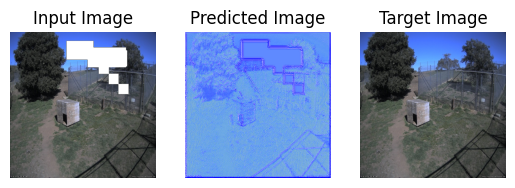

In [33]:
plt.subplot(131)
plt.imshow(x.permute(1,2,0))
plt.title("Input Image")
plt.axis("off")

plt.subplot(132)
plt.imshow(out2.squeeze().permute(1,2,0).detach().numpy())
plt.title("Predicted Image")
plt.axis("off")

plt.subplot(133)
plt.imshow(y.permute(1,2,0))
plt.title("Target Image")
plt.axis("off")

#Loss Function

In [74]:
import torch
import torchvision
from torchvision.models import vgg16


weight = torchvision.models.VGG16_Weights.DEFAULT  #.default not _DEFAULT
model = vgg16(weights = weight,progress = True)
model_without_classifier = torch.nn.Sequential(*list(model.children())[:-1])

for param in model_without_classifier.parameters():
    param.requires_grad = False

# model.features[-1]
# list(model.children())[-1]
# print(model_without_classifier)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 106MB/s]


In [35]:
import torch.nn.functional as F

sample_pred_loss = model_without_classifier(out2[:,:3,...])
sample_target_loss = model_without_classifier(y.unsqueeze(0)[:,:3,...])
sample_pred_loss.shape, sample_target_loss.shape

# lets calculate the final loss
loss2 = torch.mean((sample_pred_loss - sample_target_loss) ** 2)
# loss = 0
# for x,y in zip(sample_pred_loss, sample_target_loss):
#   loss += F.mse_loss(x,y)
loss2

tensor(0.3023, grad_fn=<MeanBackward0>)

In [75]:
# loss function (This is also quite complex in this paper)
# 1. High recptive field perpetual loss ------------------------------> Mean([model(predicted) - model(target)] ** 2)  **Model will be a segmentation model**

loss_model = model_without_classifier
def hrfp_loss(predicted, target,loss_model):
  loss_model = loss_model.to(predicted.device)
  loss_model.eval()

  with torch.inference_mode():
    predicted = loss_model(predicted[:,:3,...])  # [:,:3,...] for accoutning for batched input
    target = loss_model(target[:,:3,...])
  loss = torch.mean((predicted - target) ** 2)
  loss = torch.tensor(loss, requires_grad = True)
  return loss

# 2. Adversial Loss

#############################3 For now i wiil use only simple HRFPL loss only and leave the rest will see them if needed

In [37]:
out2.shape,y.shape

(torch.Size([1, 4, 512, 512]), torch.Size([3, 512, 512]))

In [76]:
hrfp_loss(out2,y.unsqueeze(0).cpu(), loss_model)

NameError: name 'out2' is not defined

In [77]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),

            nn.Flatten(),  # check out the shape   - 262144
            nn.Linear(841, 1),   # this is forgiving one word output whether fake or not
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

def discriminator_loss(x, out2, mask,device,dis_model):
  #out2 is pred
  m1 = dis_model(out2[:,:3,...])
  m2 = dis_model(x[:,:3,...].to(torch.float))

  disc_out_inp = m2
  out = out2
  disc_out_out = m1

  mask = mask.view(mask.shape[0],mask.shape[1]*mask.shape[2])

  Ex_logD = torch.mean(torch.log(disc_out_inp))          #log is not defined for -ve nums so its giving NaN
  Exm_logDe = torch.mean(mask * torch.log(disc_out_out))
  Exm_log1mD = torch.mean(mask * torch.log(1 - disc_out_out))
  Ez_logG = torch.mean((1 - mask) * torch.log(disc_out_out))

  LD = -Ex_logD - Exm_logDe - Exm_log1mD
  LG = -Ez_logG

  return LD + LG

In [40]:
# discriminator_loss(x, out2,)

In [78]:
def loss_calc(x,y,mask,pred,loss_model,disc_model,device):
  disc_loss = discriminator_loss(x, pred, mask,device,disc_model) # pred = out2
  hrfpLoss = hrfp_loss(pred,y, loss_model)
  total_loss = hrfpLoss + disc_loss
  return total_loss

#Training Model

In [42]:
%cd image_blend_data
!ls

[Errno 2] No such file or directory: 'image_blend_data'
/content/image_blend_data
data.py  masks	real_images  trained_100_epochs.pth


In [79]:
#lets start with training part
from torch.optim import SGD,Adam
from tqdm.auto import tqdm

# model = inpainting_model_v2()
model = inpainting_model_final()
model=Lama()
# model = torch.load("image_blend_data/trained_100_epochs.pth")

disc_model = Discriminator().float()
loss_model = model_without_classifier

# loss_fn = hrfp_loss
# loss_fn = nn.MSELoss()
loss_fn = loss_calc
optimizer = Adam(model.parameters(), lr = 0.001)
disc_optimizer = Adam(disc_model.parameters(), lr = 0.001)
disc_loss_fn = nn.BCELoss()

In [ ]:
# so our model is working fine so lets make a training loop for it
from sklearn.metrics import accuracy_score,mean_absolute_error, mean_squared_error

NUM_EPOCHS = 51
device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.float()
model.to(device)
disc_model.to(device)

print(type(model))
for epoch in tqdm(range(NUM_EPOCHS)):
  train_loss = 0
  disc_loss_train = 0
  model.train()
  for num,(x,y,m) in enumerate(train_dataloader):
    x,y,m = x.to(torch.float).to(device), y.to(torch.float).to(device), m.to(device)

    if num % 2 == 0:
      disc_pred = disc_model(y)
      disc_loss = disc_loss_fn(disc_pred.squeeze(), torch.tensor([1,1], dtype = torch.float).to(device).squeeze())

    # print(m.shape)
    pred = model(x)

    if num % 2 != 0:
      disc_pred = disc_model(pred[:,:3,...].detach())
      disc_loss = disc_loss_fn(disc_pred.squeeze(), torch.tensor([0,0], dtype = torch.float).to(device).squeeze())

    # print(pred,y)
    loss = loss_fn(x,y,m,pred, loss_model.to(device),disc_model.to(device),device)
    train_loss += loss.item()
    disc_loss_train += disc_loss.item()

    optimizer.zero_grad()   # zero grad should not be used either early or later than this as the loss was not decreasing
    disc_optimizer.zero_grad()
    loss.backward()
    disc_loss.backward(retain_graph=True)
    optimizer.step()
    disc_optimizer.step()

  test_loss = 0
  disc_loss_test = 0
  model.eval()
  with torch.inference_mode():
    for num ,(x,y,m) in enumerate(test_dataloader):
      x,y,m = x.to(torch.float).to(device), y.to(torch.float).to(device), m.to(device)

      if num % 2 == 0:
        disc_pred = disc_model(y)
        disc_loss = disc_loss_fn(disc_pred.squeeze(), torch.tensor([1,1], dtype = torch.float).to(device).squeeze())

      pred = model(x)

      if num % 2 != 0:
        disc_pred = disc_model(pred[:,:3,...].detach())
        disc_loss = disc_loss_fn(disc_pred.squeeze(), torch.tensor([0,0], dtype = torch.float).to(device).squeeze())

      loss = loss_fn(x,y,m,pred, loss_model.to(device), disc_model.to(device),device)
      disc_loss_test += disc_loss.item()
      test_loss += loss.item()

  test_loss /= len(test_dataloader)
  train_loss /= len(train_dataloader)
  disc_loss_test /=  len(test_dataloader)
  disc_loss_train /=  len(train_dataloader)

  if epoch%1 == 0:
    print(f'\nepoch : {epoch} || train loss : {train_loss} , disc_loss_train : {disc_loss_train} || test loss : {test_loss} , disc_loss_test : {disc_loss_test}')

  #LeakyRelu is a thing of use since in most of cases where relu fails leakyrelu helps

<class '__main__.Lama'>


  0%|          | 0/51 [00:00<?, ?it/s]

<ipython-input-75-0e0ecf35f3ba>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.tensor(loss, requires_grad = True)



epoch : 0 || train loss : 1.4406559952084739 , disc_loss_train : 0.2667611035096736 || test loss : 1.4449252581938765 , disc_loss_test : 0.27085785769122595

epoch : 1 || train loss : 1.4235278714231816 , disc_loss_train : 0.2697477388088324 || test loss : 1.4371017988710264 , disc_loss_test : 0.27774241726410764

epoch : 2 || train loss : 1.4411367139934488 , disc_loss_train : 0.2660796947274247 || test loss : 1.4381472912256896 , disc_loss_test : 0.2738372623302894

epoch : 3 || train loss : 1.4478950926327436 , disc_loss_train : 0.2653914637467588 || test loss : 1.4553119458085035 , disc_loss_test : 0.2672895020073156

epoch : 4 || train loss : 1.445141929639977 , disc_loss_train : 0.265952755719981 || test loss : 1.4466900868114863 , disc_loss_test : 0.26892096287588174

epoch : 5 || train loss : 1.4407903177830768 , disc_loss_train : 0.26619816082303577 || test loss : 1.4447358138706363 , disc_loss_test : 0.2720157066103184

epoch : 6 || train loss : 1.4443997858843431 , disc_los

In [ ]:
with torch.inference_mode():
  z = loss_fn(x,y,m,pred, loss_model.to(device),device)
z

In [ ]:
torch.save(model,"big_loss_model.pth")
# i think that i need to work upon loss function some more

In [46]:
x.shape,y.shape

(torch.Size([2, 4, 512, 512]), torch.Size([2, 3, 512, 512]))

In [81]:
x,y,_ = next(iter(test_dataloader))
# x[0].shape,y[0].shape
model.eval()
model.to(device)
with torch.inference_mode():
  out = model(x.to(torch.float).to(device))
out.shape

torch.Size([2, 4, 512, 512])

(-0.5, 511.5, 511.5, -0.5)

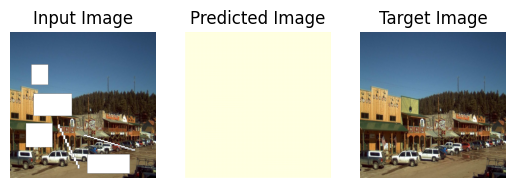

In [83]:
plt.subplot(131)
plt.imshow(x[0].to(torch.uint8).permute(1,2,0))
plt.title("Input Image")
plt.axis("off")

plt.subplot(132)
plt.imshow(out[0].squeeze().permute(1,2,0).cpu().detach().numpy())
plt.title("Predicted Image")
plt.axis("off")

plt.subplot(133)
plt.imshow(y[0].permute(1,2,0))
plt.title("Target Image")
plt.axis("off")

# making discriminator

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),

            nn.Flatten(),  # check out the shape   - 262144
            nn.Linear(841, 1),   # this is forgiving one word output whether fake or not
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

def discriminator_loss(x, out2, mask):
  #out2 is pred
  dis_model = Discriminator().float()
  m1 = dis_model(out2[:,:3,...])
  m2 = dis_model(x[:,:3,...].to(torch.float))

  disc_out_inp = m2
  out = out2
  disc_out_out = m1

  mask = mask.view(1,512*512)

  Ex_logD = torch.mean(torch.log(disc_out_inp))          #log is not defined for -ve nums so its giving NaN
  Exm_logDe = torch.mean(mask * torch.log(disc_out_out))
  Exm_log1mD = torch.mean(mask * torch.log(1 - disc_out_out))
  Ez_logG = torch.mean((1 - mask) * torch.log(disc_out_out))

  LD = -Ex_logD - Exm_logDe - Exm_log1mD
  LG = -Ez_logG

  return LD + LG

In [ ]:
x,y,m = train_dataset[0]
x.shape, y.shape, m.shape, out2.shape

In [ ]:
# supposing that x and y are samples from traindataset
dis_model = Discriminator().float()
m1 = dis_model(out2[:,:3,...])
m2 = dis_model(x[:3,...].unsqueeze(0).to(torch.float))
m3 = dis_model(y.unsqueeze(0))
print(m1.squeeze(), m2.squeeze(), m3.squeeze())

In [ ]:
disc_out_inp = m2 # it is discriminators output on the x values i.e. input
out = out2 # the output from inpainting model
disc_out_out = m1 # output of discriminator on output of impainting model
mask = m # mask of each image

mask = mask.view(1,512*512)

# loss_disc = torch.mean(torch.log(disc_out_inp)) - torch.mean(torch.log(disc_out_out @ mask)) - torch.mean(torch.log((1 - disc_out_out) @ (1 - mask)))
# loss_gen = torch.mean(torch.log(disc_out_out))
# loss_adv = torch.sigmoid(loss_disc) + torch.sigmoid(loss_gen)
# loss_adv

Ex_logD = torch.mean(torch.log(disc_out_inp))          #log is not defined for -ve nums so its giving NaN
Exm_logDe = torch.mean(mask * torch.log(disc_out_out))
Exm_log1mD = torch.mean(mask * torch.log(1 - disc_out_out))
Ez_logG = torch.mean((1 - mask) * torch.log(disc_out_out))
# print(Ex_logD, Exm_logDe, Exm_log1mD, Ez_logG)

LD = -Ex_logD - Exm_logDe - Exm_log1mD
LG = -Ez_logG

LD + LG


In [ ]:
def discriminator_loss(x, out2, mask):
  #out2 is pred
  dis_model = Discriminator().float()
  m1 = dis_model(out2[:,:3,...])
  m2 = dis_model(x[:,:3,...].to(torch.float))

  disc_out_inp = m2
  out = out2
  disc_out_out = m1

  mask = mask.view(1,512*512)

  Ex_logD = torch.mean(torch.log(disc_out_inp))          #log is not defined for -ve nums so its giving NaN
  Exm_logDe = torch.mean(mask * torch.log(disc_out_out))
  Exm_log1mD = torch.mean(mask * torch.log(1 - disc_out_out))
  Ez_logG = torch.mean((1 - mask) * torch.log(disc_out_out))

  LD = -Ex_logD - Exm_logDe - Exm_log1mD
  LG = -Ez_logG

  return LD + LG

In [ ]:
discriminator_loss(x, out2 ,m)

In [ ]:
torch.log(torch.tensor(-0.1736))

#Extra

In [ ]:
from torchinfo import summary
summary(model,
        input_size = (8,4,512,512))

In [ ]:
# model for HRF PERPETUAL LOSS
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
model = maskrcnn_resnet50_fpn(weights=weights, progress=False)

model = model.float()
model.eval()
with torch.inference_mode():
  output = model([x[:3,...].to(torch.float)])
  print(output)

In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights


weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

model = fasterrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()
model = model.float()
outputs = model([x[:3,...].to(torch.float), out.squeeze()[:3,...].to(torch.float) ])
print(outputs)

tryy = x[:3,...]#.unsqueeze(0).shape
plt.imshow(tryy.permute(1,2,0))

In [ ]:
data_path = Path("")
imgs = list((data_path/"real_images").glob("*.jpg"))
masks = list((data_path/"masks").glob("*.png"))

x = data_path / "real_images"
list(x.glob("*.jpg"))
# since we already have masks in our dataset then why we are making them
from PIL import  Image
data_path = Path("")   # dont use PAth("/") for cwd

imgs = list((data_path / "real_images").glob("*.jpg"))
masks = list((data_path / "masks").glob("*.png"))
masked_imgs = data_path / "masked_imgs/"
masked_imgs.mkdir(parents=True, exist_ok=True)

imgs = sorted(imgs)
masks = sorted(masks)
images = []
masked_imgs = []

for i,j in zip(imgs, masks):
  if i.as_posix().split('/')[-1].split('.')[0]  + "_1" == j.as_posix().split('/')[-1].split('.')[0]:
    img_s = Image.open(i)
    mask_s = Image.open(j)

    img_s = transform(img_s)
    mask_s = transform(mask_s)
    images.append(img_s)

    # print(img_s.shape, mask_s.shape)
    img_s[mask_s == 0] == 0
    masked_imgs.append(img_s)
# code for other method of dataser
from pathlib import Path
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split

class inpaint_dataset(Dataset):
  def __init__(self,split : str = "train" ):
    self.imgs = images
    self.masks = masked_imgs

    self.train_imgs,self.test_imgs= train_test_split((self.imgs, self.masks), test_size = 0.3,random_state = 42)
    if split == "train":
      print(self.train_imgs)
      self.imgs, self.masks = self.train_imgs

    else:
      self.imgs,self.masks = self.test_imgs
    # print(self.imgs[0])

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    img = self.imgs[idx]
    maskd = self.masks[idx]

    return torch.cat((img,maskd.unsqueeze(0)), dim = 0), img ;  # blurred image and correct image